# Model Training and Predictions

In [85]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.feature_selection import chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression 
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import neighbors
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn import model_selection as ms
from sklearn.model_selection import cross_val_score, cross_val_predict

sklearn.set_config(print_changed_only=False)

from xgboost.sklearn import XGBRegressor

from matplotlib import pyplot as plt

from ipynb.fs.full.functions_sheet import col_obj_list, nan_col_list, cols_nan_unique, nan_col_obj_list_fillna
from ipynb.fs.full.functions_sheet import fill_masvnrtype, rmse

In [2]:
hp_tree_fullyimputed = pd.read_csv('../hp_tree_fullyimputed.csv')
hp_linear_fullyimputed = pd.read_csv('../hp_linear_fullyimputed.csv')

hp_tree_fullyimputed

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GarageYrModified
0,60,6,65.0,8450,2,0,1,1,1,1,1,6,3,3,1,4,7,5,2003,2003,2,2,15,15,2,196.0,2,3,3,2,3,4,1,706,6,0,150,856,2,1,1,1,856,854,0,1710,1,0,2,1,3,1,2,8,1,0,0,2,2003.0,2,2,548,3,3,1,0,61,0,0,0,0,0,0,0,0,2,2008,1,1,2003
1,20,6,80.0,9600,2,0,1,1,1,4,1,25,2,3,1,1,6,8,1976,1976,2,2,9,9,4,0.0,3,3,2,2,3,1,2,978,6,0,284,1262,2,1,1,1,1262,0,0,1262,0,1,2,0,3,1,3,6,1,1,3,2,1976.0,2,2,460,3,3,1,298,0,0,0,0,0,0,0,0,0,5,2007,1,1,1976
2,60,6,68.0,11250,2,0,2,1,1,1,1,6,3,3,1,4,7,5,2001,2002,2,2,15,15,2,162.0,2,3,3,2,3,3,1,486,6,0,434,920,2,1,1,1,920,866,0,1786,1,0,2,1,3,1,2,6,1,1,3,2,2001.0,2,2,608,3,3,1,0,42,0,0,0,0,0,0,0,0,9,2008,1,1,2001
3,70,6,60.0,9550,2,0,2,1,1,2,1,7,3,3,1,4,7,5,1915,1970,2,2,16,17,4,0.0,3,3,1,3,2,4,2,216,6,0,540,756,2,2,1,1,961,756,0,1717,1,0,1,0,3,1,2,7,1,1,2,6,1998.0,3,3,642,3,3,1,0,35,272,0,0,0,0,0,0,0,2,2006,1,2,1915
4,60,6,84.0,14260,2,0,2,1,1,4,1,14,3,3,1,4,8,5,2000,2000,2,2,15,15,2,350.0,2,3,3,2,3,2,1,655,6,0,490,1145,2,1,1,1,1145,1053,0,2198,1,0,2,1,4,1,2,9,1,1,3,2,2000.0,2,3,836,3,3,1,192,84,0,0,0,0,0,0,0,0,12,2008,1,1,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,62.0,7917,2,0,1,1,1,1,1,9,3,3,1,4,6,5,1999,2000,2,2,15,15,4,0.0,3,3,3,2,3,4,6,0,6,0,953,953,2,1,1,1,953,694,0,1647,0,0,2,1,3,1,3,7,1,1,3,2,1999.0,2,2,460,3,3,1,0,40,0,0,0,0,0,0,0,0,8,2007,1,1,1999
1456,20,6,85.0,13175,2,0,1,1,1,1,1,17,3,3,1,1,6,6,1978,1988,2,2,11,11,5,119.0,3,3,2,2,3,4,2,790,4,163,589,1542,2,3,1,1,2073,0,0,2073,1,0,2,0,3,1,3,7,2,2,3,2,1978.0,3,2,500,3,3,1,349,0,0,0,0,0,0,2,0,0,2,2010,1,1,1978
1457,70,6,66.0,9042,2,0,1,1,1,1,1,7,3,3,1,4,7,9,1941,2006,2,2,6,6,4,0.0,1,2,5,3,2,4,1,275,6,0,877,1152,2,1,1,1,1188,1152,0,2340,0,0,2,0,4,1,2,9,1,2,2,2,1941.0,2,1,252,3,3,1,0,60,0,0,0,0,0,1,4,2500,5,2010,1,1,1941
1458,20,6,68.0,9717,2,0,1,1,1,1,1,13,3,3,1,1,5,6,1950,1996,4,2,9,9,4,0.0,3,3,2,3,3,3,1,49,4,1029,0,1078,2,2,1,2,1078,0,0,1078,1,0,1,0,2,1,2,5,1,0,0,2,1950.0,3,1,240,3,3,1,366,0,112,0,0,0,0,0,0,0,4,2010,1,1,1950


In [3]:
hp_linear_fullyimputed

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GarageYrModified,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_DNE,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_DNE,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_DNE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_DNE,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageTy

In [4]:
hp_logsaleprice = pd.read_csv('../hp_logsaleprice.csv')

hp_logsaleprice

,SalePrice
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216
...,...
1455,12.072541
1456,12.254863
1457,12.493130
1458,11.864462


# *Penalized Linear Regressions*

In [5]:
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_linear_fullyimputed, hp_logsaleprice, test_size=0.2, random_state=0)

ytrain = ytrain.values.flatten()

In [7]:
lasso = Lasso(random_state=0, max_iter=1000000, normalize=True)

n_folds_lin = ms.KFold(n_splits=5, random_state=0, shuffle=True)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000, normalize=True, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-08, 3.44827587e+00, 6...
       4.13793104e+01, 4.48275862e+01, 4.82758621e+01, 5.17241379e+01,
       5.51724138e+01, 5.86206897e+01, 6.20689655e+01, 6.55172414e+01,
       6.89655172e+01, 7.24137931e+01, 7.58620690e+01, 7.93103448e+01,
       8.27586207e+01, 8.62068966e+01, 8.96551724e+01, 9.31034483e+01,
       9.65517241e+01, 1.00000000e+02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)
######################

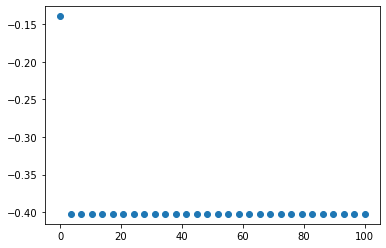

In [8]:
alphas = np.linspace(1e-8, 1e2, 30)

gparam_lasso = [{'alpha': alphas}]

gs_lasso = GridSearchCV(lasso, gparam_lasso, cv=n_folds_lin, scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_lasso.fit(xtrain, ytrain))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_lasso.best_params_)

print('where the alpha is: ', gs_lasso.best_params_['alpha'])

print('#'*50)
print('\n')

print('The best score is: ', gs_lasso.best_estimator_.score(xtrain, ytrain))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_lasso, ytrain, xtrain))

plt.scatter(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000, normalize=True, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-08, 3.44924138e-05, 6...
       4.13798966e-04, 4.48281379e-04, 4.82763793e-04, 5.17246207e-04,
       5.51728621e-04, 5.86211034e-04, 6.20693448e-04, 6.55175862e-04,
       6.89658276e-04, 7.24140690e-04, 7.58623103e-04, 7.93105517e-04,
       8.27587931e-04, 8.62070345e-04, 8.96552759e-04, 9.31035172e-04,
       9.65517586e-04, 1.00000000e-03])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)
######################

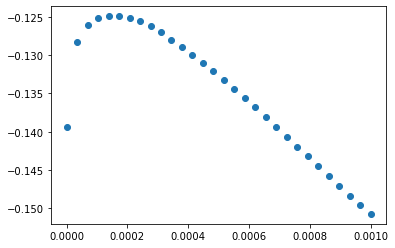

In [9]:
alphas = np.linspace(1e-8, 1e-3, 30)

gparam_lasso = [{'alpha': alphas}]

gs_lasso = GridSearchCV(lasso, gparam_lasso, cv=n_folds_lin, scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_lasso.fit(xtrain, ytrain)

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_lasso.best_params_)

print('where the alpha is: ', gs_lasso.best_params_['alpha'])

print('#'*50)
print('\n')

print('The best score is: ', gs_lasso.best_estimator_.score(xtrain, ytrain))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_lasso, ytrain, xtrain))

plt.scatter(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])

In [35]:
dir(gs_lasso)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_check_n_features',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_

The test set RMSE is:  0.22081517033230433


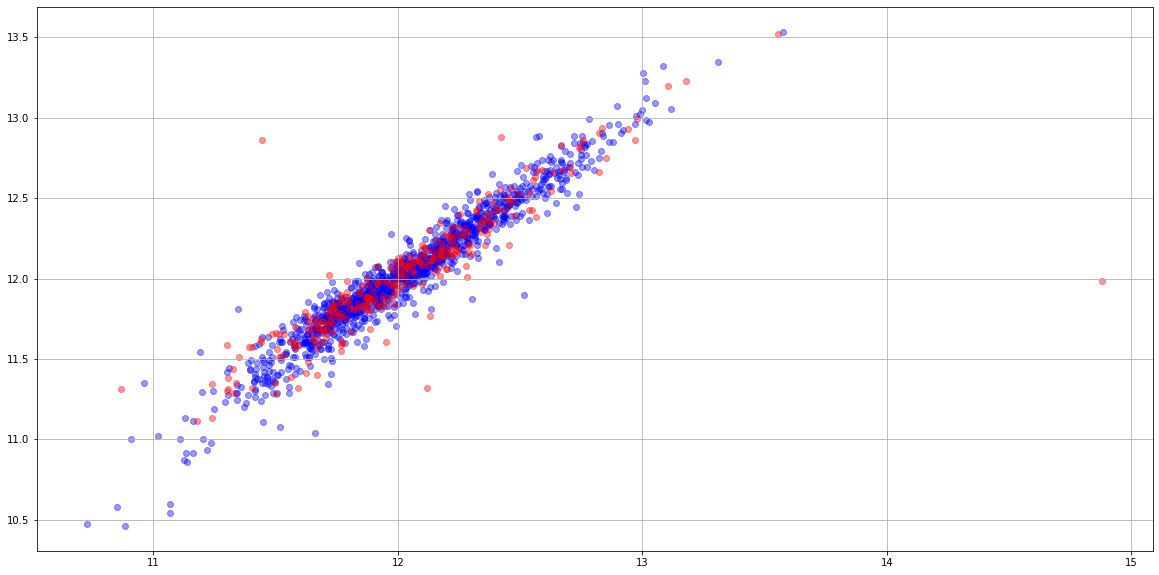

In [134]:
print('The test set RMSE is: ', rmse(gs_lasso, ytest, xtest))

plt.figure(figsize=(20, 10))
plt.scatter(gs_lasso.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_lasso.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

### Select more important features

In [212]:
lasso = Lasso(alpha=gs_lasso.best_params_['alpha'], random_state=0, max_iter=1000000, normalize=True)

lasso.fit(xtrain, ytrain)

lasso_coef = pd.Series(lasso.coef_)

lasso_coef_index = [i for i, x in enumerate(lasso_coef) if abs(x) > 0]

hp_linear_selected = hp_linear_fullyimputed.iloc[:,lasso_coef_index]

hp_linear_selected

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,ScreenPorch,GarageYrModified,MSZoning_C (all),MSZoning_FV,MSZoning_RM,Alley_Pave,LotShape_IR2,LotShape_Reg,LotConfig_CulDSac,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NridgHt,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Artery,Condition1_Norm,Condition1_RRAe,Condition2_PosN,BldgType_1Fam,BldgType_Twnhs,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_Wd Sdng,MasVnrType_Stone,ExterQual_TA,ExterCond_Fa,Foundation_PConc,BsmtQual_Ex,BsmtCond_Fa,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_GLQ,BsmtFinType2_BLQ,Heating_Grav,HeatingQC_Ex,HeatingQC_Fa,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_TA,Functional_Maj2,Functional_Typ,FireplaceQu_DNE,GarageType_2Types,GarageType_Attchd,GarageFinish_Unf,GarageQual_Gd,GarageCond_TA,PavedDrive_N,PoolQC_Gd,Fence_GdWo,SaleType_CWD,SaleType_ConLD,SaleType_New,SaleCondition_Abnorml,LotFrontage
0,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.575425,-0.288653,-0.459303,0.370333,1.107810,0.789741,1.227585,-0.211454,-0.951226,0.296026,0.311725,0.351000,-0.752176,0.216503,-0.270208,1.050994,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,-0.229372
1,-0.091886,-0.071836,2.179628,0.156734,-0.429577,1.171992,-0.288653,0.466465,-0.482512,-0.819964,0.789741,-0.761621,-0.211454,0.600495,0.236495,0.311725,-0.060731,1.626195,-0.704483,-0.270208,0.156734,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.451936
2,0.073480,0.651479,-0.517200,0.984752,0.830215,0.092907,-0.288653,-0.313369,0.515013,1.107810,0.789741,1.227585,-0.211454,0.600495,0.291616,0.311725,0.631726,-0.752176,-0.070361,-0.270208,0.984752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,-0.093110
3,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.499274,-0.288653,-0.687324,0.383659,1.107810,-1.026041,-0.761621,-0.211454,0.600495,0.285002,1.650307,0.790804,-0.752176,-0.176048,-0.270208,-1.863632,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,-0.456474
4,0.375148,1.374795,-0.517200,0.951632,0.733308,0.463568,-0.288653,0.199680,1.299326,1.107810,0.789741,1.227585,-0.211454,0.600495,0.289412,1.650307,1.698485,0.780197,0.563760,-0.270208,0.951632,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.633618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.973018,-0.288653,-0.238122,0.250402,-0.819964,0.789741,1.227585,-0.211454,0.600495,0.287207,0.311725,-0.060731,-0.752176,-0.100558,-0.270208,0.918511,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,-0.365633
1456,0.266407,-0.071836,0.381743,0.222975,0.151865,0.759659,0.722112,1.104925,1.061367,1.107810,0.789741,-0.761621,-0.211454,2.152216,0.240904,0.311725,0.126420,2.033231,-0.704483,-0.270208,0.222975,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0.679039
1457,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.369871,-0.288653,0.215641,1.569647,-0.819964,0.789741,-0.761621,-0.211454,2.152216,0.159324,-1.026858,-1.033914,-0.752176,0.201405,-0.270208,-1.002492,0,0,

### Determining Outliers

#### Outlier on right side

In [198]:
# Create dataframe of xtest predictions
df_xtest = pd.DataFrame(gs_lasso.predict(xtest))
df_xtest.rename(columns={0:'SalePrice'}, inplace=True)

# Determine the highest value of the xtest predictions
plug_in = df_xtest[df_xtest['SalePrice']==gs_lasso.predict(xtest).max()]

# Plug that value into ytest to get the 'name' (which is actually the index) of the value 
ytest.iloc[plug_in.index]

,SalePrice
1298,11.982929


#### Outlier on Left Side

In [194]:
# Creates list of indices that are within the specified bounds of ytest
ytest_ind = list(ytest[(ytest['SalePrice']>12.75) & (ytest['SalePrice']<13)]['SalePrice'].index)

# check for the indices around where our target may lie on the x axis
df_xtest[(df_xtest['SalePrice']>11.3) & (df_xtest['SalePrice']<11.6)]

# Creates list of indices that are within the specified bounds of df_xtest
xtest_ind = list(df_xtest[(df_xtest['SalePrice']>11.3) & (df_xtest['SalePrice']<11.6)]['SalePrice'].index)

# Creates list of indices that are within the specified bounds of ytest using xtest_ind
comparison_list = list(ytest.iloc[xtest_ind]['SalePrice'].index)
set(ytest_ind) & set(comparison_list)

{825}

## Delete both of the outliers in the features and labels

In [207]:
hp_tree_fullyimputed = hp_tree_fullyimputed.drop(1298).drop(825)

hp_linear_fullyimputed = hp_linear_fullyimputed.drop(1298).drop(825)

hp_logsaleprice = hp_logsaleprice.drop(1298).drop(825)

hp_linear_selected = hp_linear_selected.drop(1298).drop(825)

KeyError: '[1298] not found in axis'

## Re-run Lasso

In [217]:
xtrain_sel, xtest_sel, ytrain_sel, ytest_sel = ms.train_test_split(hp_linear_selected,
                                                                   hp_logsaleprice, 
                                                                   test_size=0.2,
                                                                   random_state=0)

ytrain_sel = ytrain_sel.values.flatten()

In [218]:
lasso = Lasso(random_state=0, max_iter=1000000, normalize=True)

n_folds_lin = ms.KFold(n_splits=5, random_state=0, shuffle=True)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000, normalize=True, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-08, 3.44924138e-05, 6...
       4.13798966e-04, 4.48281379e-04, 4.82763793e-04, 5.17246207e-04,
       5.51728621e-04, 5.86211034e-04, 6.20693448e-04, 6.55175862e-04,
       6.89658276e-04, 7.24140690e-04, 7.58623103e-04, 7.93105517e-04,
       8.27587931e-04, 8.62070345e-04, 8.96552759e-04, 9.31035172e-04,
       9.65517586e-04, 1.00000000e-03])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)
######################

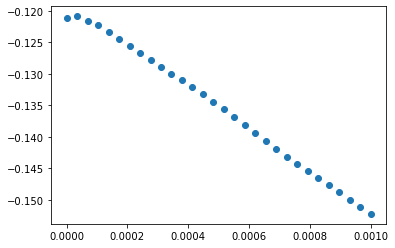

In [219]:
alphas = np.linspace(1e-8, 1e-3, 30)

gparam_lasso = [{'alpha': alphas}]

gs_lasso = GridSearchCV(lasso, gparam_lasso, cv=n_folds_lin, scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_lasso.fit(xtrain_sel, ytrain_sel)

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_lasso.best_params_)

print('where the alpha is: ', gs_lasso.best_params_['alpha'])

print('#'*50)
print('\n')

print('The best score is: ', gs_lasso.best_estimator_.score(xtrain_sel, ytrain_sel))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_lasso, ytrain_sel, xtrain_sel))

plt.scatter(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])

The test set RMSE is:  0.11474801005943151


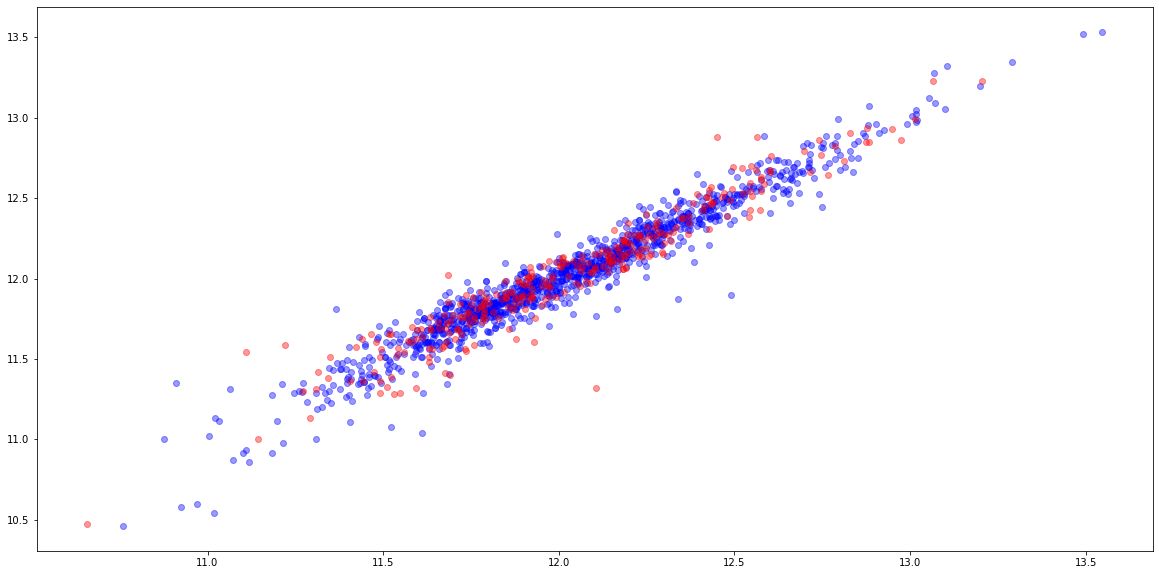

In [220]:
print('The test set RMSE is: ', rmse(gs_lasso, ytest_sel, xtest_sel))

plt.figure(figsize=(20, 10))
plt.scatter(gs_lasso.predict(xtrain_sel), ytrain_sel, color='blue', alpha=0.4)
plt.scatter(gs_lasso.predict(xtest_sel), ytest_sel, color='red', alpha=0.4)

# Run Multi Linear Regression

In [221]:
lm = LinearRegression()

scores = cross_val_score(lm, xtrain_sel, ytrain_sel, scoring='neg_root_mean_squared_error', cv=5)
print(scores)
print(np.mean(scores))

[-1.22077765e-01 -9.98674392e+07 -1.14252231e-01 -2.32061125e+02
 -8.88635090e-02]
-19973534.308305226


In [222]:
lm.fit(xtrain_sel, ytrain_sel)
lm.score(xtrain_sel, ytrain_sel)

0.9420670465284626

In [223]:
lm = LinearRegression()

fitintercept = [True, False]
norm = [True, False]
# copyx = [True, False]

gparam_mlr = {'fit_intercept': fitintercept,
              'normalize': norm}

gs_mlr = ms.GridSearchCV(lm, gparam_mlr, cv=n_folds_lin, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_mlr.fit(xtrain_sel, ytrain_sel)

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_mlr.best_params_)

# print('where the alpha is: ', gs_mlr.best_params_['alpha'])
# print('and the L1 ratio is: ', gs_mlr.best_params_['l1_ratio'])

print('#'*50)
print('\n')

print('The best score is: ', gs_mlr.best_estimator_.score(xtrain_sel, ytrain_sel))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_mlr, ytrain_sel, xtrain_sel))

Wall time: 3.93 s
##################################################


Currently, the best parameters are:  {'fit_intercept': True, 'normalize': True}
##################################################


The best score is:  0.9421634529811027
##################################################


The RMSE is:  0.09541911933643527


The test set RMSE is:  0.11504447162416538


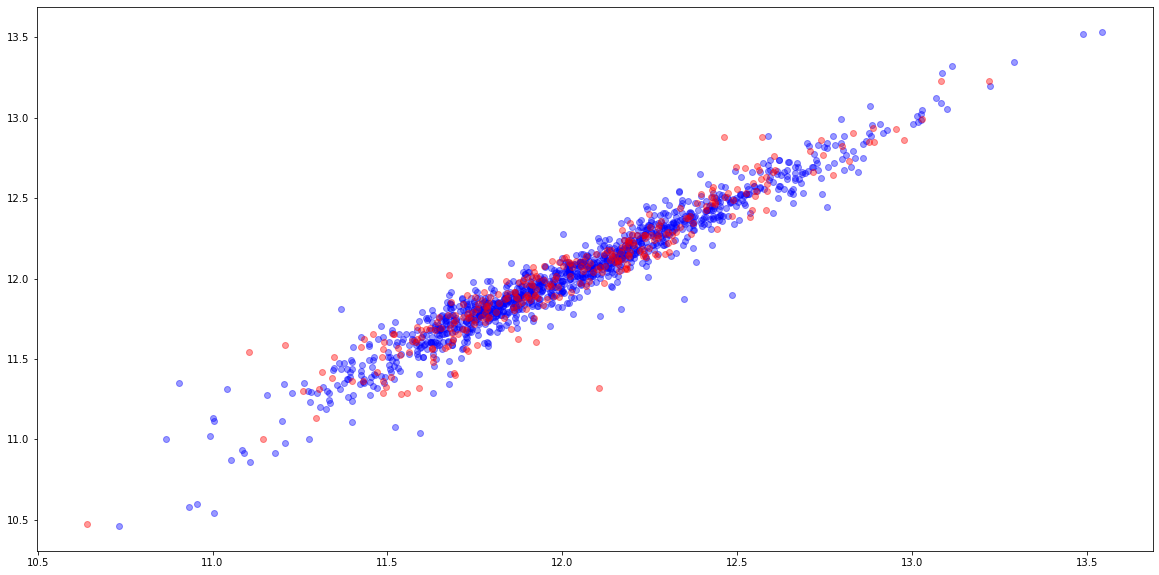

In [224]:
print('The test set RMSE is: ', rmse(gs_mlr, ytest_sel, xtest_sel))

plt.figure(figsize=(20, 10))
plt.scatter(gs_mlr.predict(xtrain_sel), ytrain_sel, color='blue', alpha=0.4)
plt.scatter(gs_mlr.predict(xtest_sel), ytest_sel, color='red', alpha=0.4)

# Run Elastic Net

Wall time: 8min 25s
##################################################


Currently, the best parameters are:  {'alpha': 8.286427728546843e-05, 'l1_ratio': 0.026826957952797274}
where the alpha is:  8.286427728546843e-05
and the L1 ratio is:  0.026826957952797274
##################################################


The best score is:  0.9399643362432496
##################################################


The RMSE is:  0.0972162543088787


C:\Users\tdcho\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


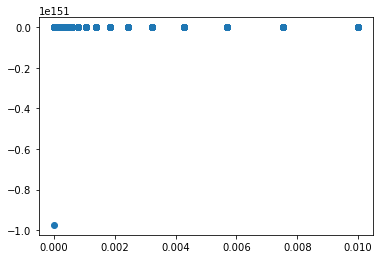

In [227]:
enet = ElasticNet(random_state=0, max_iter=10000, normalize=True)

alphas = np.logspace(-8, -2, 50)
rhos = np.logspace(-8, 1, 50)

gparam_enet = {'l1_ratio': rhos, 'alpha': alphas}

gs_enet = GridSearchCV(enet, gparam_enet, cv=n_folds_lin, refit=True, n_jobs=-1,
                       scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet.fit(xtrain_sel, ytrain_sel)

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_enet.best_params_)

print('where the alpha is: ', gs_enet.best_params_['alpha'])
print('and the L1 ratio is: ', gs_enet.best_params_['l1_ratio'])

print('#'*50)
print('\n')

print('The best score is: ', gs_enet.best_estimator_.score(xtrain_sel, ytrain_sel))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_enet, ytrain_sel, xtrain_sel))

plt.scatter(gs_enet.cv_results_['param_alpha'], gs_enet.cv_results_['mean_test_score'])

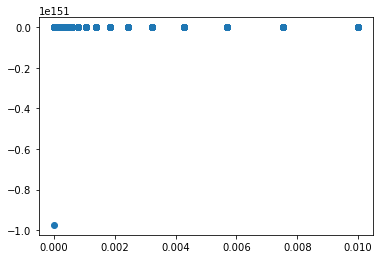

In [228]:
plt.scatter(gs_enet.cv_results_['param_alpha'], gs_enet.cv_results_['mean_test_score'])

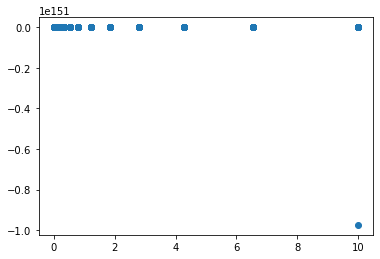

In [229]:
plt.scatter(gs_enet.cv_results_['param_l1_ratio'], gs_enet.cv_results_['mean_test_score'])

# WHY AM I GETTING THIS ERROR?

### Is it related to the error we encountered above?

In [230]:
print('The test set RMSE is: ', rmse(gs_enet, ytest_sel, xtest_sel))

The test set RMSE is:  0.11685089359581653


Wall time: 22.1 s
##################################################


Currently, the best parameters are:  {'alpha': 0.001, 'l1_ratio': 0.001}
where the alpha is:  0.001
and the L1 ratio is:  0.001
##################################################


The best score is:  0.9370997801669658
##################################################


The RMSE is:  0.09950852923286092


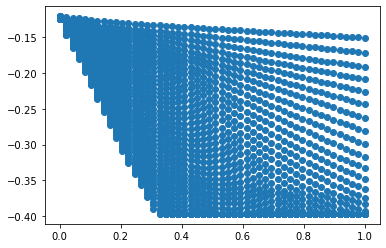

In [232]:
enet = ElasticNet(random_state=0, max_iter=10000)

alphas = np.linspace(1e-3, 1, 50)
rhos = np.linspace(1e-3, 1, 50)

gparam_enet = {'l1_ratio': rhos, 'alpha': alphas}

gs_enet = GridSearchCV(enet, gparam_enet, cv=n_folds_lin, refit=True, n_jobs=-1,
                       scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet.fit(xtrain_sel, ytrain_sel)

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_enet.best_params_)

print('where the alpha is: ', gs_enet.best_params_['alpha'])
print('and the L1 ratio is: ', gs_enet.best_params_['l1_ratio'])

print('#'*50)
print('\n')

print('The best score is: ', gs_enet.best_estimator_.score(xtrain_sel, ytrain_sel))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_enet, ytrain_sel, xtrain_sel))

plt.scatter(gs_enet.cv_results_['param_alpha'], gs_enet.cv_results_['mean_test_score'])

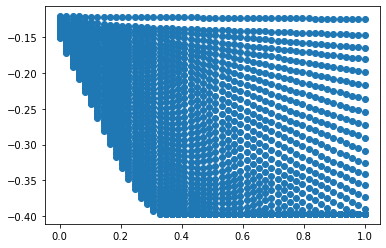

In [233]:
# These graphs do not show us much, but they are fun to see :]

plt.scatter(gs_enet.cv_results_['param_l1_ratio'], gs_enet.cv_results_['mean_test_score'])

In [234]:
print('The test set RMSE is: ', rmse(gs_enet, ytest_sel, xtest_sel))

The test set RMSE is:  0.11389595617707937


## Gradient Boosting Regressions

In [235]:
xtrain_gb, xtest_gb, ytrain_gb, ytest_gb = ms.train_test_split(hp_tree_fullyimputed, 
                                                               hp_logsaleprice, test_size=0.2, random_state=0)

ytrain_gb = ytrain_gb.values.flatten()

### 1st Run

In [21]:
gbm = GradientBoostingRegressor()

learningrate = [0.0001, 0.001, 0.01, 0.1, 1] # subsequently, fine tune
nestimators = [5, 10, 50, 100, 200, 500, 1000, 1500, 2000, 5000]

maxfeatures = [9, 40, len(hp_tree_fullyimputed.columns)]
maxdepth = range(1, 5)

gparam_gbm = {'learning_rate': learningrate,
              'n_estimators': nestimators, 
              'max_features': maxfeatures,
              'max_depth': maxdepth}

n_folds=ms.KFold(n_splits=5, random_state=0, shuffle=True)

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1, 
                      scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_gbm.fit(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_gbm.best_params_)

print('where the alpha is: ', gs_gbm.best_params_['learning_rate'])
print('and the L1 ratio is: ', gs_gbm.best_params_['n_estimators'])
print('where the alpha is: ', gs_gbm.best_params_['max_features'])
print('and the L1 ratio is: ', gs_gbm.best_params_['max_depth'])

print('#'*50)
print('\n')

print('The best score is: ', gs_gbm.best_estimator_.score(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_gbm, ytrain_gb, xtrain_gb))

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight...
                                                 subsample=1.0, tol=0.0001,
                                     

### Test Set Comparison:

The test set RMSE is:  0.12229139868989768


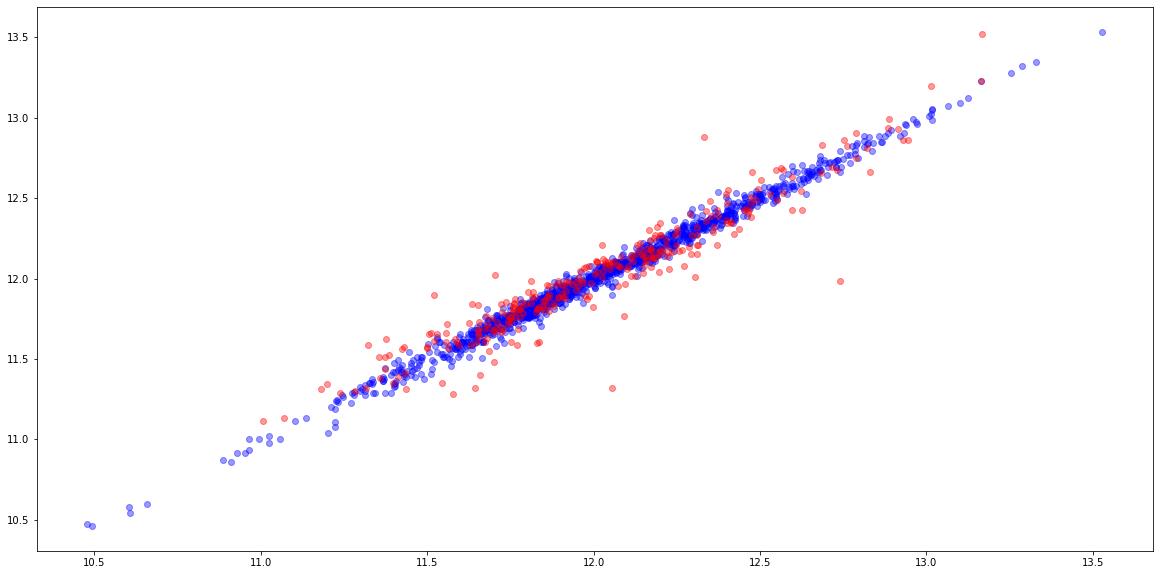

In [22]:
print('The test set RMSE is: ', rmse(gs_gbm, ytest_gb, xtest_gb))

plt.figure(figsize=(20, 10))
plt.scatter(gs_gbm.predict(xtrain_gb), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.predict(xtest_gb), ytest, color='red', alpha=0.4)

#### There is quite a big difference between the RMSE of the train and test

In [23]:
gbm = GradientBoostingRegressor(random_state=0,
                                loss='ls',
                                min_impurity_decrease=0.1,
                                warm_start=False)

learningrate = [0.0001, 0.001, 0.01, 0.1, 1] # subsequently, fine tune
nestimators = [5, 10, 50, 100, 200, 500, 1000, 1500, 2000, 5000]

maxfeatures = [9, 40, len(hp_tree_fullyimputed.columns)]
maxdepth = range(1, 5)

gparam_gbm = {'learning_rate': learningrate,
              'n_estimators': nestimators,
              'max_features': maxfeatures,
              'max_depth': maxdepth}

n_folds=ms.KFold(n_splits=5, random_state=0, shuffle=True)

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1, 
                      scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_gbm.fit(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_gbm.best_params_)

print('where the alpha is: ', gs_gbm.best_params_['learning_rate'])
print('and the L1 ratio is: ', gs_gbm.best_params_['n_estimators'])
print('where the alpha is: ', gs_gbm.best_params_['max_features'])
print('and the L1 ratio is: ', gs_gbm.best_params_['max_depth'])

print('#'*50)
print('\n')

print('The best score is: ', gs_gbm.best_estimator_.score(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_gbm, ytrain_gb, xtrain_gb))

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.1,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight...
                                                 tol=0.0001,
                                                 val

The test set RMSE is:  0.13009876536563167


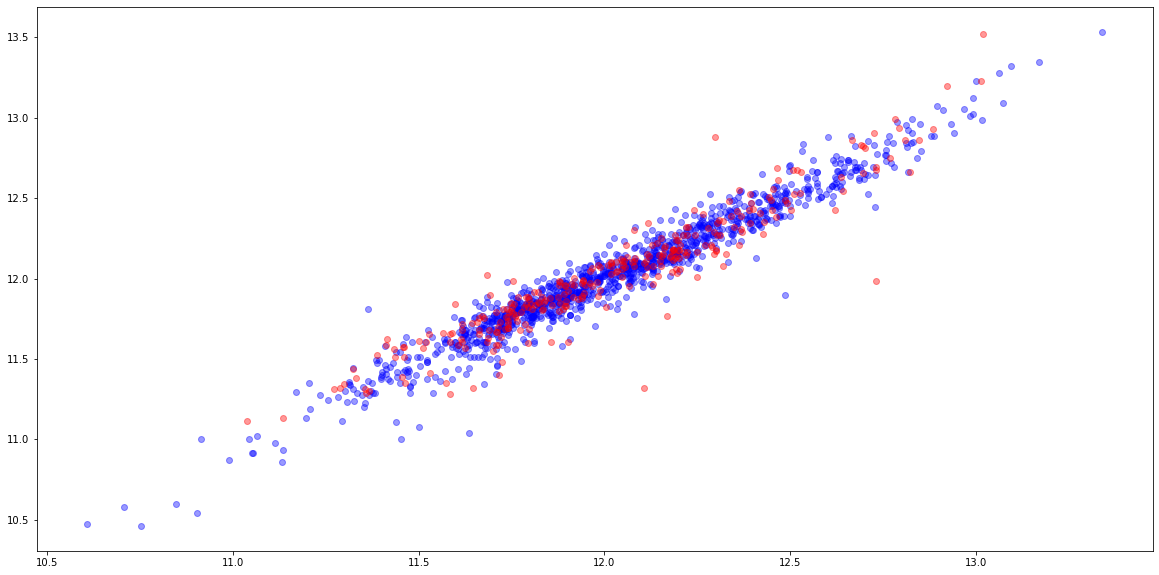

In [24]:
print('The test set RMSE is: ', rmse(gs_gbm, ytest_gb, xtest_gb))

plt.figure(figsize=(20, 10))
plt.scatter(gs_gbm.predict(xtrain_gb), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.predict(xtest_gb), ytest, color='red', alpha=0.4)

In [25]:
gbm = GradientBoostingRegressor(random_state=0)

learningrate = np.logspace(-3, -1, 20) 
nestimators = np.linspace(3000, 7000, 20)
maxfeatures = list(range(1, 20))
maxdepth = list(range(1, 5))

gparam_gbm = {'learning_rate': learningrate,
              'n_estimators': nestimators, 
              'max_features': maxfeatures,
              'max_depth': maxdepth}

n_folds=ms.KFold(n_splits=5, random_state=0, shuffle=True)

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1, 
                      scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_gbm.fit(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_gbm.best_params_)

print('where the alpha is: ', gs_gbm.best_params_['learning_rate'])
print('and the L1 ratio is: ', gs_gbm.best_params_['n_estimators'])
print('where the alpha is: ', gs_gbm.best_params_['max_features'])
print('and the L1 ratio is: ', gs_gbm.best_params_['max_depth'])

print('#'*50)
print('\n')

print('The best score is: ', gs_gbm.best_estimator_.score(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_gbm, ytrain_gb, xtrain_gb))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
print('The test set RMSE is: ', rmse(gs_gbm, ytest_gb, xtest_gb))

plt.figure(figsize=(20, 10))
plt.scatter(gs_gbm.predict(xtrain_gb), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.predict(xtest_gb), ytest, color='red', alpha=0.4)

In [ ]:
print(gs_gbm.best_params_)
print(gs_gbm.best_score_)

## XGBoost

In [45]:
xgb = XGBRegressor(random_state=0, eval_method='rmse')

In [39]:
xgb

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eval_method='rmse',
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, learning_rate=None,
             max_delta_step=None, max_depth=None, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, objective='reg:squarederror',
             random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [28]:
maxdepth = range(2, 6)
eta_ = np.linspace(1e-2, 1, 10)
gamma_ = np.linspace(1e-5, 100, 30)
subsample_ = np.linspace(0, 1, 3)
# updater_ = [grow_colmaker,prune,grow_gpu_hist]

n_folds=ms.KFold(n_splits=5, random_state=0, shuffle=True)

gparam_xgb = {'max_depth': maxdepth,
              'eta': eta_,
              'gamma': gamma_,
              'subsample': subsample_}

gs_xgb = GridSearchCV(xgb, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1, 
                      scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_xgb.fit(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_xgb.best_params_)

print('where the learning rate is: ', gs_xgb.best_params_['eta'])
print('and the L1 ratio is: ', gs_xgb.best_params_['max_depth'])
print('where the alpha is: ', gs_xgb.best_params_['gamma'])
print('and the L1 ratio is: ', gs_xgb.best_params_['subsample'])

print('#'*50)
print('\n')

print('The best score is: ', gs_xgb.best_estimator_.score(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_xgb, ytrain_gb, xtrain_gb))

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    mi...
       5.51724183e+01, 5.86206938e+01, 6.20689693e+01, 6.55172448e+01,
       6.89655203e+01, 7.24137959e+01, 7.58620714e+01, 7.93103469e+01,
       8.27586224e+01, 8.62068979e+01, 8.96551734e+01, 9.31034490e+01,
       9.65517245e+01, 1.00000000e+02]),
                         'max_depth': range(2, 6),
          

In [49]:
gs_xgb.cv_results_

{'mean_fit_time': array([0.5306603 , 0.59104338, 0.52438135, ..., 0.21239972, 1.00230031,
        1.00429955]),
 'std_fit_time': array([0.01911111, 0.00809987, 0.11815281, ..., 0.01315443, 0.03631291,
        0.03812599]),
 'mean_score_time': array([0.00619988, 0.00729918, 0.00652547, ..., 0.00639992, 0.00609965,
        0.00539985]),
 'std_score_time': array([0.00039986, 0.00067954, 0.00104403, ..., 0.00131904, 0.00048877,
        0.00058301]),
 'param_eta': masked_array(data=[0.01, 0.01, 0.01, ..., 1.0, 1.0, 1.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1e-05, 1e-05, 1e-05, ..., 100.0, 100.0, 100.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 2, 2, ..., 5, 5, 5],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',


The test set RMSE is:  0.13215847683560447


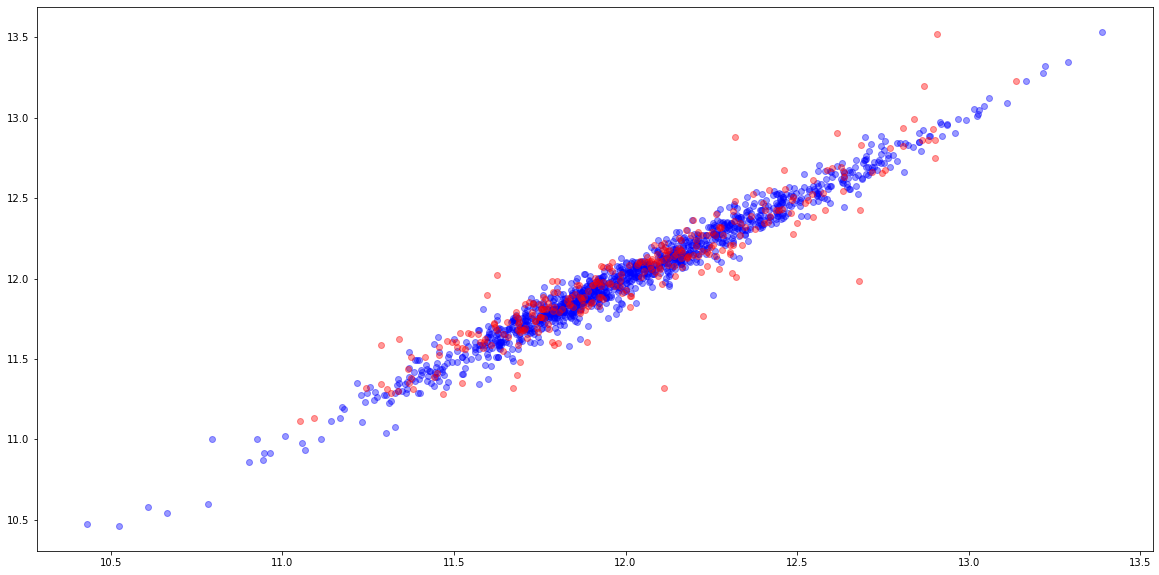

In [29]:
print('The test set RMSE is: ', rmse(gs_xgb, ytest_gb, xtest_gb))

plt.figure(figsize=(20, 10))
plt.scatter(gs_xgb.predict(xtrain_gb), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb.predict(xtest_gb), ytest, color='red', alpha=0.4)

In [ ]:
### Due to the low RMSE, we will attempt XGBoost with 

In [42]:
hp_nonimpute = pd.read_csv('../hp_nonimpute.csv')
hp_nonimpute

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,6,65.0,8450,2,NaN,1,1,1,1,1,6,3,3,1,4,7,5,2003,2003,2,2,15,15,2.0,196.0,2,3,3,2.0,3.0,4.0,1.0,706,6.0,0,150,856,2,1,1,1.0,856,854,0,1710,1,0,2,1,3,1,2,8,1,0,NaN,2.0,2003.0,2.0,2,548,3.0,3.0,1,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,1,1
1,20,6,80.0,9600,2,NaN,1,1,1,4,1,25,2,3,1,1,6,8,1976,1976,2,2,9,9,4.0,0.0,3,3,2,2.0,3.0,1.0,2.0,978,6.0,0,284,1262,2,1,1,1.0,1262,0,0,1262,0,1,2,0,3,1,3,6,1,1,3.0,2.0,1976.0,2.0,2,460,3.0,3.0,1,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,1,1
2,60,6,68.0,11250,2,NaN,2,1,1,1,1,6,3,3,1,4,7,5,2001,2002,2,2,15,15,2.0,162.0,2,3,3,2.0,3.0,3.0,1.0,486,6.0,0,434,920,2,1,1,1.0,920,866,0,1786,1,0,2,1,3,1,2,6,1,1,3.0,2.0,2001.0,2.0,2,608,3.0,3.0,1,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,1,1
3,70,6,60.0,9550,2,NaN,2,1,1,2,1,7,3,3,1,4,7,5,1915,1970,2,2,16,17,4.0,0.0,3,3,1,3.0,2.0,4.0,2.0,216,6.0,0,540,756,2,2,1,1.0,961,756,0,1717,1,0,1,0,3,1,2,7,1,1,2.0,6.0,1998.0,3.0,3,642,3.0,3.0,1,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,1,2
4,60,6,84.0,14260,2,NaN,2,1,1,4,1,14,3,3,1,4,8,5,2000,2000,2,2,15,15,2.0,350.0,2,3,3,2.0,3.0,2.0,1.0,655,6.0,0,490,1145,2,1,1,1.0,1145,1053,0,2198,1,0,2,1,4,1,2,9,1,1,3.0,2.0,2000.0,2.0,3,836,3.0,3.0,1,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,62.0,7917,2,NaN,1,1,1,1,1,9,3,3,1,4,6,5,1999,2000,2,2,15,15,4.0,0.0,3,3,3,2.0,3.0,4.0,6.0,0,6.0,0,953,953,2,1,1,1.0,953,694,0,1647,0,0,2,1,3,1,3,7,1,1,3.0,2.0,1999.0,2.0,2,460,3.0,3.0,1,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,1,1
1456,20,6,85.0,13175,2,NaN,1,1,1,1,1,17,3,3,1,1,6,6,1978,1988,2,2,11,11,5.0,119.0,3,3,2,2.0,3.0,4.0,2.0,790,4.0,163,589,1542,2,3,1,1.0,2073,0,0,2073,1,0,2,0,3,1,3,7,2,2,3.0,2.0,1978.0,3.0,2,500,3.0,3.0,1,349,0,0,0,0,0,NaN,2.0,NaN,0,2,2010,1,1
1457,70,6,66.0,9042,2,NaN,1,1,1,1,1,7,3,3,1,4,7,9,1941,2006,2,2,6,6,4.0,0.0,1,2,5,3.0,2.0,4.0,1.0,275,6.0,0,877,1152,2,1,1,1.0,1188,1152,0,2340,0,0,2,0,4,1,2,9,1,2,2.0,2.0,1941.0,2.0,1,252,3.0,3.0,1,0,60,0,0,0,0,NaN,1.0,4.0,2500,5,2010,1,1
1458,20,6,68.0,9717,2,NaN,1,1,1,1,1,13,3,3,1,1,5,6,1950,1996,4,2,9,9,4.0,0.0,3,3,2,3.0,3.0,3.0,1.0,49,4.0,1029,0,1078,2,2,1,2.0,1078,0,0,1078,1,0,1,0,2,1,2,5,1,0,NaN,2.0,1950.0,3.0,1,240,3.0,3.0,1,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,1,1


In [43]:
xtrain_nonimpute, xtest_nonimpute, ytrain_nonimpute, ytest_nonimpute = ms.train_test_split(hp_tree_fullyimputed, 
                                                                                           hp_logsaleprice, 
                                                                                           test_size=0.2, 
                                                                                           random_state=0)

ytrain_nonimpute = ytrain_nonimpute.values.flatten()

In [48]:
dir(xgb)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 '_wrap_evaluation_matrices',
 'apply',
 'base_score',
 'booster',
 'coef_',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'evals_result',
 'feature_importances_',
 'fit',
 'gamma',
 'get_booster',
 'get_num_boosting_rounds',
 'get_params',
 'get_xgb_params',
 'gpu_id',
 'importance_type',
 'interaction_constraints',
 'intercept_',
 'kwargs',
 'learning_rate',
 'lo

In [47]:
xgb = XGBRegressor(random_state=0)

xgb.fit(xtrain_nonimpute, ytrain_nonimpute)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
maxdepth = range(2, 6)
eta_ = np.linspace(1e-2, 1, 10)
gamma_ = np.linspace(1e-5, 100, 30)
subsample_ = np.linspace(0, 1, 3)
# updater_ = [grow_colmaker,prune,grow_gpu_hist]

n_folds=ms.KFold(n_splits=5, random_state=0, shuffle=True)

gparam_xgb = {'max_depth': maxdepth,
              'eta': eta_,
              'gamma': gamma_,
              'subsample': subsample_}

gs_xgb = GridSearchCV(xgb, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1, 
                      scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_xgb.fit(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_xgb.best_params_)

print('where the learning rate is: ', gs_xgb.best_params_['eta'])
print('and the L1 ratio is: ', gs_xgb.best_params_['max_depth'])
print('where the alpha is: ', gs_xgb.best_params_['gamma'])
print('and the L1 ratio is: ', gs_xgb.best_params_['subsample'])

print('#'*50)
print('\n')

print('The best score is: ', gs_xgb.best_estimator_.score(xtrain_gb, ytrain_gb))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_xgb, ytrain_gb, xtrain_gb))